In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.fft import fft, ifft

from sklearn.metrics import r2_score

from ymaeda_tools.read_dGM import read_Mseq1, read_dseq1, read_dimseq2, readall_mest
from ymaeda_tools.inversion import winv_lstsq
from ymaeda_tools.dft import exidft_timeshift, dft, idft, halfdft_timeshift, timeshift_cplx

# This script verifies that the python functions performing the moment tensor linear inversion return
# the same results as the original YMAEDA_TOOLS functions

base = "/Users/ynatsume/jupyter_main/Shinmoedake Data/"
main_dir = base + "inversion_result_residuals117/t60_p100/x-10900y-121100z1000/"

# time step used by YMAEDA_TOOLS
dt = 0.1 
# frequency step size used by YMAEDA_TOOLS
df = 0.002441406 
# frequency half space used by YMAEDA_TOOLS
f = np.arange(0, df * 2049, df) 
# frequency full space used by YMAEDA_TOOLS
F = np.arange(0, df * 4096, df) 

In [2]:
# There are 4 folders output by YMAEDA_TOOLS that are associated with the inverted seismic moment tensor:
#     1. model/M.seq1 is the final time series of the inverted seismic moment tensor M(t).
#     2. model_spectrum/M.imseq2 is the Fourier transform of model/M.seq1.
#     3. d_obs/dX.cv and G/G.dbm data which inverts to the estimated moment tensor
#     4. m_est/mX.cv is the direct output from the inversion algorithm.

# 1. model/M.seq1
mt = read_Mseq1(main_dir)
print("model/M.seq1 shape:", mt.shape)

# 2. model_spectrum/M.imseq2
mt_freq, mt_spec = read_dimseq2(main_dir + "model_spectrum/", "M.imseq2")
print("model_spectrum/M.imseq2 shape:", mt_spec.shape)

# 3. Linear inversion (with python code) using the data in G/G.dbm and d_obs/dX.cv...
mest = winv_lstsq(main_dir, w = 0)
print("mest.shape: {}".format(mest.shape))

# 4. m_est/mX.cv
mest_ym = readall_mest(main_dir)
print("mest/mX.cv shape:", mest_ym.shape)

t = np.arange(0, dt * len(mt), dt) # np.array of time steps

model/M.seq1 shape: (4096,)
model_spectrum/M.imseq2 shape: (4096,)
mest.shape: (2049, 2)
mest/mX.cv shape: (2049, 2)


In [3]:
STARTTIME = time.time()

# The DFT of M.seq1, and the other 3 data sets already stored in frequency space should equal each other...
# Also, the raw M.seq1 data, the moment tensor calculated from G.dbm and dX.cv, and the IDFT of M.imseq2
# should all give the same numerical time series!
# Let's confirm that here.

# 1. Perform a DFT, time shift 1000 indices and halve the frequency space of model/M.seq1
mest_rev = halfdft_timeshift(mt, D = 1000) * dt # don't forget the dt factor!!!
print("np.shape(mest_rev): {}".format(np.shape(mest_rev)))

# 2. Perform a IDFT on the time shifted model_spectrum/M.imseq2
mt_spec_idft = np.real(idft(timeshift_cplx(mt_spec, D = 1000)) / dt) # don't forget the 1/dt factor!!!
print("np.shape(mt_spec_idft): {}".format(np.shape(mt_spec_idft)))

# 3. IDFT mest to time domain. Remember the 1/dt factor, and time shift 1000 indices
# discard the imaginary part still hanging around due to numerical errors
mr = np.real(exidft_timeshift(mest, D = 1000) / dt)
print("np.shape(mr): {}".format(np.shape(mr)))

# 4. also IDFT mest_ym to time domain. 
mest_ym_t = np.real(exidft_timeshift(mest_ym, D = 1000) / dt)
print("np.shape(M.seq1): {}".format(np.shape(mt)))

print("Time elapsed: {:.3f}s".format(time.time() - STARTTIME))

np.shape(mest_rev): (2049,)
np.shape(mt_spec_idft): (4096,)
np.shape(mr): (4096,)
np.shape(M.seq1): (4096,)
Time elapsed: 2.390s


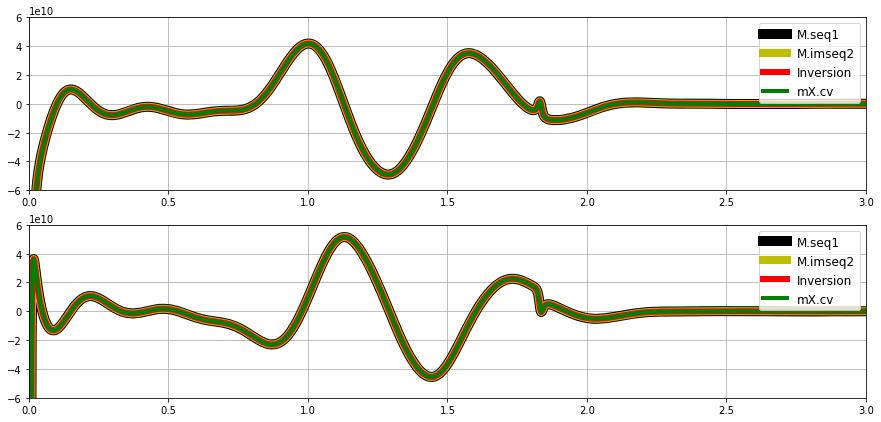

In [4]:
plt.figure(figsize = (15, 7))
plt.subplot(2, 1, 1)
# 1. DFT of M.seq1:
plt.plot(f, np.real(mest_rev),"k", linewidth = 10)
# 2. Raw M.imseq2 data:
plt.plot(mt_freq, np.real(mt_spec), "y", linewidth = 8)
# 3. Moment tensor calculated from dX.cv and G.dbm using python code:
plt.plot(f, mest[:, 0], "r", linewidth = 6)
# 4. Raw mX.cv data
plt.plot(f, mest_ym[:, 0], "g", linewidth = 4)
plt.ylim([-0.6e11, 0.6e11])
plt.xlim([0, 3])
plt.grid(True)
plt.legend(["M.seq1", "M.imseq2", "Inversion", "mX.cv"], fontsize = 12)
plt.subplot(2, 1, 2)
# 1. DFT of M.seq1:
plt.plot(f, np.imag(mest_rev),"k", linewidth = 10)
# 2. Raw M.imseq2 data:
plt.plot(mt_freq, np.imag(mt_spec), "y", linewidth = 8)
# 3. Moment tensor calculated from dX.cv and G.dbm using python code:
plt.plot(f, mest[:, 1], "r", linewidth = 6)
# 4. Raw mX.cv data
plt.plot(f, mest_ym[:, 1], "g", linewidth = 4)
plt.ylim([-0.6e11, 0.6e11])
plt.xlim([0, 3])
plt.grid(True)
plt.legend(["M.seq1", "M.imseq2", "Inversion", "mX.cv"], fontsize = 12)
plt.show()

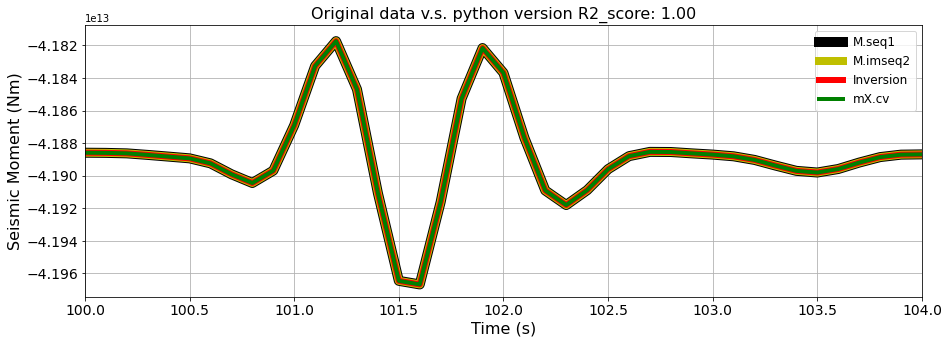

In [5]:
plt.figure(figsize = (15, 5))
plt.title("Original data v.s. python version R2_score: {:.2f}".format(r2_score(mt, mr)), fontsize = 16)
# 1. Loaded raw model/M.seq1 data:
plt.plot(t, mt, "k", linewidth = 10)
# 2. IDFT of model_spectrum/M.imseq2 data:
plt.plot(t, mt_spec_idft, "y", linewidth = 8)
# 3. Moment tensor calculated from dX.cv and G.dbm using python code:
plt.plot(t, mr, "r", linewidth = 6)
# 4. mX.cv data:
plt.plot(t, mest_ym_t, "g", linewidth = 4)
plt.xlabel('Time (s)', fontsize = 16)
plt.ylabel('Seismic Moment (Nm)', fontsize = 16)
plt.legend(["M.seq1", "M.imseq2", "Inversion", "mX.cv"], fontsize = 12)
plt.grid(True)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim([100, 104])
plt.show()

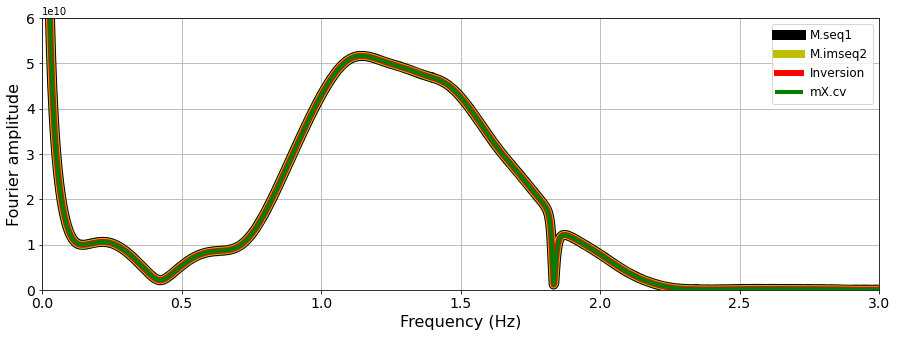

In [6]:
# Therer is an ultra-long period signal within the final result... We are not interested in that.
# Check where the most interesting portion of the moment tensor spectrum is...

plt.figure(figsize = (15, 5))
# 1. DFT of M.seq1:
plt.plot(f, np.abs(mest_rev),"k", linewidth = 10)
# 2. Raw M.imseq2 data:
plt.plot(mt_freq, np.abs(mt_spec), "y", linewidth = 8)
# 3. Moment tensor calculated from dX.cv and G.dbm using python code:
plt.plot(f, np.sqrt(mest[:, 0]**2 + mest[:, 1]**2), "r", linewidth = 6)
# 4. Raw mX.cv data
plt.plot(f, np.sqrt(mest_ym[:, 0]**2 + mest_ym[:, 1]**2), "g", linewidth = 4)
plt.xlabel("Frequency (Hz)", fontsize = 16)
plt.ylabel("Fourier amplitude", fontsize = 16)
plt.grid(True)
plt.ylim([0, 0.6e11])
plt.xlim([0, 3])
plt.legend(["M.seq1", "M.imseq2", "Inversion", "mX.cv"], fontsize = 12)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

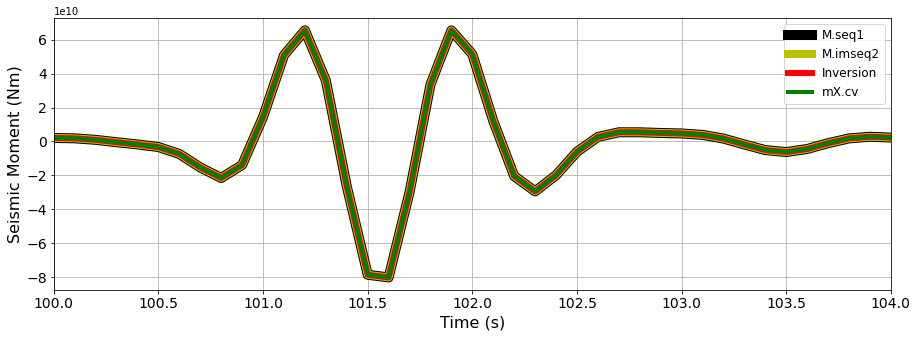

In [7]:
# Try filtering out the ultra-long period signal by focussing on the band [0.5, 2.5] Hz. This should "zero"
# and scale the moment tensor to something more reasonable.

b, a = signal.iirfilter(2, [0.5, 2.5], btype='bandpass', analog=False, ftype='butter', fs=1/dt, output='ba')

mtX = signal.filtfilt(b, a, mt)
mt_spec_idftX = signal.filtfilt(b, a, mt_spec_idft)
mrX = signal.filtfilt(b, a, mr)
mest_ym_tX = signal.filtfilt(b, a, mest_ym_t)

plt.figure(figsize = (15, 5))
# 1. Loaded raw model/M.seq1 data:
plt.plot(t, mtX, "k", linewidth = 10)
# 2. IDFT of model_spectrum/M.imseq2 data:
plt.plot(t, mt_spec_idftX, "y", linewidth = 8)
# 3. Moment tensor calculated from dX.cv and G.dbm using python code:
plt.plot(t, mrX, "r", linewidth = 6)
# 4. mX.cv data:
plt.plot(t, mest_ym_tX, "g", linewidth = 4)
plt.xlabel('Time (s)', fontsize = 16)
plt.ylabel('Seismic Moment (Nm)', fontsize = 16)
plt.legend(["M.seq1", "M.imseq2", "Inversion", "mX.cv"], fontsize = 12)
plt.grid(True)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim([100, 104])
plt.show()